# Denoising Autoencoders - Lab

## Introduction

In this lab, we will build a simple de-noising autoencoder using a shallow architecture. Following the approach in previously seen in the section, the simple architecture can be replaced by a deep network having multiple layers to learn the intermediate representation. The basic architecture remains the same here , however, the application area changes from data compression to data de-noising. Let's get on with it . 

## Objectives

You will be able to:

- Build a simple denoising Autoencoder architecture in Keras
- Add random Gaussian Noise to a given images dataset
- Predict a clean image from a (previously unseen) noisy image


## Load necessary libraries

We need to first load necessary libraries including numpy and keras for building our DAE model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, Input
import warnings
warnings.filterwarnings("ignore")

## Load data

This experiment can be performed with any small image database, to help us keep our focus on the architecture and the approach. You can try with MNIST, fashion-MNIST, CIFAR10 and CIFAR100 datasets. CIFAR datasets are colored images and carry RGB channels which can possibly increase the training times many folds. You are encouraged to try these and other larger datasets with this code and give it a few hours (maybe overnight) training time to run a bigger experiment. 

Let's perform following tasks first, similar to our previous labs

- Load MNIST/fashion-MNIST dataset in keras (both datasets contain images with similar dimensions). Create train and test datasets
- Neural networks only accepts row vectors as an input - Reshape train and test datasets from 2D array to 1D. 
- Scale the data in range [0,1] to allow us to use sigmoid activation function in output neurons.
- Print the shape of resulting datasets

In [2]:
from keras.datasets import fashion_mnist

img_rows, img_cols = 28, 28
input_shape = (img_rows * img_cols, )

(X_train, _), (X_test, _) = fashion_mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print('MNIST\n')
print(X_train.shape[0], 'training samples')
print(X_test.shape[0], 'training samples')

MNIST

60000 training samples
10000 training samples


## Create a "Noisy" Dataset

Here we will introduce random Gaussian noise to the test and train data. The noiy dataset can be generated using following general formula, which will a add noise with mean 0 and standard deviation=1 :

$$NoisyDataset~=~OriginalDataset~+~NoiseFactor~*~np.random.normal(loc=0.0, scale=1.0, size=OriginalDataset.shape)$$

- Use a noise factor of 0.5
- Create a set of noise test and train datasets from original datasets using formula given above
- Use `np.clip()` to restrict the values between 0 and 1. 


> __numpy.clip(a, a_min, a_max, out=None)__ clips (limit) the values in an array.

*Given an interval, values outside the interval are clipped to the interval edges. For example, if an interval of [0, 1] is specified, values smaller than 0 become 0, and values larger than 1 become 1.*


In [3]:
noise_factor = 0.5
X_train_noisy = X_train + noise_factor*np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor*np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

## Build the DAE

- Build the encoder model for creating a hidden representation of length 32 from input vector of length 784. 
- Use RELU activation for the encoder model
- Build the decoder model with signmoid activation 
- Show model summary

In [4]:
x = Input(name='inputs', shape=input_shape, dtype='float32')
encoder = Dense(32, activation='relu')(x)
decoder = Dense(input_shape[0], activation='sigmoid')(encoder)

DAE = Model(inputs=x, outputs=decoder)
DAE.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


## Compile and Predict 

- Use batch size = 128 and 30 epochs for training (increase epochs for better results)
- Use adam optimizer and binary cross entropy as the loss measure to compile DAE model
- Fit DAE with noisy dataset as the input and original dataset as the output. We are trying to teach the network to learn how a clean version compares to the noisy version of data - for all images. 
- Set `shuffle=True` for shuffling batches of data. 
- Make predictions with the noise test dataset

In [5]:
batch_size=128
epochs=30
DAE.compile(optimizer='adam', loss='binary_crossentropy')
DAE.fit(X_train_noisy, X_train, epochs=epochs, batch_size=batch_size, shuffle=True, 
        validation_data=(X_test_noisy, X_test))
decoded_imgs = DAE.predict(X_test_noisy)

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 3s 47us/step - loss: 0.3921 - val_loss: 0.3404
Epoch 2/30
60000/60000 [==============================] - 2s 39us/step - loss: 0.3298 - val_loss: 0.3267
Epoch 3/30
60000/60000 [==============================] - 3s 46us/step - loss: 0.3207 - val_loss: 0.3204
Epoch 4/30
60000/60000 [==============================] - 2s 41us/step - loss: 0.3155 - val_loss: 0.3160
Epoch 5/30
60000/60000 [==============================] - 2s 41us/step - loss: 0.3117 - val_loss: 0.3128
Epoch 6/30
60000/60000 [==============================] - 2s 40us/step - loss: 0.3091 - val_loss: 0.3114
Epoch 7/30
60000/60000 [==============================] - 2s 40us/step - loss: 0.3072 - val_loss: 0.3092
Epoch 8/30
60000/60000 [==============================] - 3s 43us/step - loss: 0.3059 - val_loss: 0.3083
Epoch 9/30
60000/60000 [==============================] - 3s 4

## View the results 

- Show the first ten images from the clean dataset.  
- Show the images with added noise and images predicted by the DAE. 

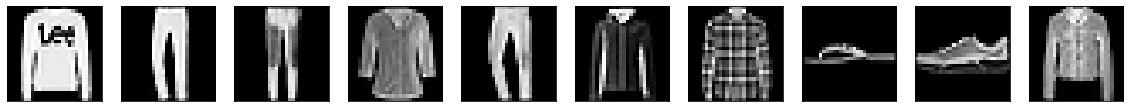

In [7]:
n=10
plt.figure(figsize = (20,4))
for i in range(1, n+1):
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

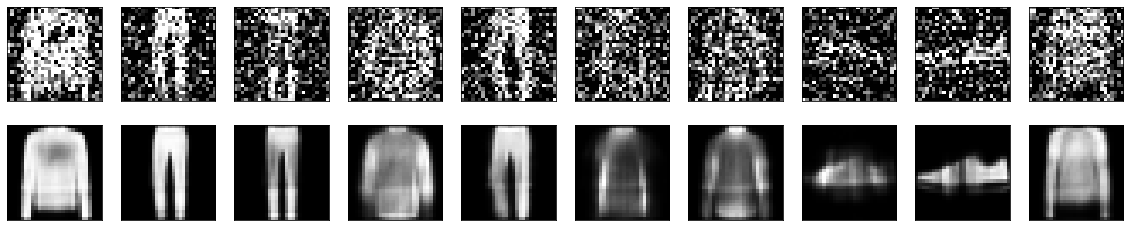

In [9]:
# Display noisy and  predicted clean imagesn = 10
plt.figure(figsize=(20, 4))
for i in range(1,n+1):

    # display noisy dataset
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Here we can see that the our model is actually performing very well. We do see some poor predictions above due to highly reduced dimensionality and high noise we have introduced in our dataset. We can further inspect the performance by checking the training and validation loss above. As always , a key takeaway here is the number of training examples and training time have a huge impact on the performance of a deep architecture. 

## Level up - Optional

- Increase the size of encoded representation / decrease the amount of noise to see if the performance improves. 
- See how training epochs effect the performance
- Import the faces dataset that we saw with PCA dimensionality reduction lab from scikit-learn, and repeat the above experiment. 
- Look for other interesting datasets/create your own noise datasets and train the network.
- Create a DEEP denoising autoencoder by modifying the code above. 

## Summary 

In this lab we looked at building a simple denoising autoencoder. We created noisy datasets by adding random Gaussian noise to the fashion MNIST dataset in keras. Our results show that the network is able to identify the shapes very well , but due to using a hugely oversimplified architecture , the accuracy remains questionable. Next we'll see how we can use convolutional network approach to simplify the task of image reconstruction.